### Carga de Datos y Selección de Variables Relevantes

Este notebook comienza con la preparación de los datos orientada a un modelo predictivo, priorizando variables con alta capacidad informativa. Aquí se detallan los pasos iniciales.

---

#### Librerías

Se cargan librerías fundamentales para el análisis de datos y aprendizaje automático:

* `pandas` y `numpy`: para manejo de datos estructurados.
* `RandomForestClassifier`: modelo robusto y flexible basado en árboles.
* `train_test_split` y `cross_val_score`: para validación y evaluación del modelo.
* `accuracy_score`: métrica para medir la precisión del clasificador.
* `matplotlib.pyplot`: para generar visualizaciones, como gráficas de importancia de variables.

---

#### Carga de Datos

Se cargan dos archivos CSV:

* `train.csv`: contiene los datos con la variable objetivo (`RENDIMIENTO_GLOBAL`).
* `test.csv`: contiene datos similares sin etiquetas, usado para predicción.

También se imprime la dimensión de ambos conjuntos como una forma rápida de verificación.

---

#### Selección de Columnas Más Informativas

Se eligen variables que combinan **características socioeconómicas, académicas y contextuales** del estudiante:

* Valor de matrícula, estrato, acceso a internet, nivel educativo de padres.
* Horas semanales de trabajo y si paga su propia matrícula.
* Departamento y programa académico que cursa.

Estas variables se consideran claves para predecir el rendimiento académico.

---

#### Limpieza de Valores Raros

Los datasets pueden contener códigos como `98`, `99` o `999` que representan respuestas desconocidas o no aplicables.

Estos valores son reemplazados por `NaN` (valores faltantes) para tratarlos adecuadamente más adelante (imputación).


In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Shape train:", train.shape)
print("Shape test :", test.shape)

cols = [
    'ESTU_VALORMATRICULAUNIVERSIDAD',
    'FAMI_ESTRATOVIVIENDA',
    'FAMI_TIENEINTERNET',
    'FAMI_EDUCACIONPADRE',
    'FAMI_EDUCACIONMADRE',
    'ESTU_HORASSEMANATRABAJA',
    'ESTU_PAGOMATRICULAPROPIO',
    'ESTU_PRGM_DEPARTAMENTO',
    'ESTU_PRGM_ACADEMICO'
]

train = train[['ID'] + cols + ['RENDIMIENTO_GLOBAL']]
test = test[['ID'] + cols]

valores_raros = ['98', '99', '999', 98, 99, 999]
for col in cols:
    train[col] = train[col].replace(valores_raros, np.nan)
    test[col] = test[col].replace(valores_raros, np.nan)

Shape train: (692500, 21)
Shape test : (296786, 20)


### Preprocesamiento Avanzado y Entrenamiento del Modelo

A partir de esta sección se preparan los datos para que puedan ser utilizados eficazmente por el modelo de aprendizaje automático. Esto incluye el tratamiento de valores faltantes, codificación, división para validación y entrenamiento.

---

#### Imputación Explícita por Valor Conocido

Se reemplazan los valores faltantes con **valores definidos manualmente**, basados en el conocimiento del dominio o análisis previo. Por ejemplo:

* Estrato imputado como `'Estrato 2'`
* Departamento como `'ANTIOQUIA'`
* Programa académico como `'ADMINISTRACIÓN DE EMPRESAS'`

Este enfoque busca representar condiciones típicas o frecuentes dentro del contexto educativo colombiano.

---

#### Codificación One-Hot

Las variables categóricas se transforman usando **One-Hot Encoding**, creando columnas binarias para cada categoría distinta.
Esto permite que el modelo interprete correctamente estas variables sin asumir orden entre categorías.

Después del encoding, se **alinean las columnas del conjunto de prueba** con las del entrenamiento para asegurar que tengan la misma estructura. Las categorías ausentes en `test` se rellenan con ceros.

---

#### Codificación de la Variable Objetivo

La variable `RENDIMIENTO_GLOBAL` se transforma en una variable numérica ordinal:

* `bajo` → 0
* `medio-bajo` → 1
* `medio-alto` → 2
* `alto` → 3

Este mapeo permite que el modelo trate el problema como una clasificación multiclase.

---

#### División para Validación

Se divide el conjunto de entrenamiento en:

* **70% entrenamiento** (`Xtrain`, `ytrain`)
* **30% validación** (`Xval`, `yval`)

Esto permite medir el rendimiento del modelo antes de aplicarlo al conjunto de prueba.

---

#### Entrenamiento con Random Forest

Se entrena un modelo **Random Forest**, que es un ensamble de árboles de decisión.

Parámetros del modelo:

* `n_estimators=100`: se construyen 100 árboles.
* `max_depth=10`: se limita la profundidad para evitar sobreajuste.
* `random_state=42`: para asegurar reproducibilidad.


In [2]:
imputacion = {
    'FAMI_ESTRATOVIVIENDA': 'Estrato 2',
    'FAMI_TIENEINTERNET': 'No',
    'FAMI_EDUCACIONPADRE': 'Secundaria (Bachillerato) completa',
    'FAMI_EDUCACIONMADRE': 'Secundaria (Bachillerato) completa',
    'ESTU_VALORMATRICULAUNIVERSIDAD': 'Entre 1 millón y menos de 2.5 millones',
    'ESTU_HORASSEMANATRABAJA': 'Entre 11 y 20 horas',
    'ESTU_PAGOMATRICULAPROPIO': 'No',
    'ESTU_PRGM_DEPARTAMENTO': 'ANTIOQUIA',
    'ESTU_PRGM_ACADEMICO': 'ADMINISTRACIÓN DE EMPRESAS'
}

for col, valor in imputacion.items():
    train[col] = train[col].fillna(valor)
    test[col] = test[col].fillna(valor)

def one_hot(df, col):
    dummies = pd.get_dummies(df[col], prefix=col)
    return pd.concat([df.drop(columns=[col]), dummies], axis=1)

for col in cols:
    train = one_hot(train, col)
    test = one_hot(test, col)

test = test.reindex(columns=train.drop(columns=['RENDIMIENTO_GLOBAL']).columns, fill_value=0)

mapa = {'bajo': 0, 'medio-bajo': 1, 'medio-alto': 2, 'alto': 3}
inv_mapa = {v: k for k, v in mapa.items()}
y = train['RENDIMIENTO_GLOBAL'].map(mapa)
X = train.drop(columns=['RENDIMIENTO_GLOBAL'])

Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
clf.fit(Xtrain, ytrain)

RandomForestClassifier(max_depth=10, random_state=42)

### Evaluación del Modelo, Predicción Final y Análisis de Variables

Una vez entrenado el modelo, se realiza su evaluación con datos no vistos, se generan las predicciones finales para el conjunto de prueba y se analizan las variables más influyentes.

---

#### Evaluación del Modelo

Se evalúa el desempeño del modelo entrenado mediante dos enfoques:

* **Accuracy en validación**: se compara la predicción (`yval_pred`) frente a las etiquetas reales (`yval`) en el conjunto de validación.
  Esto permite medir la capacidad del modelo para generalizar a datos nuevos.

* **Validación cruzada (Cross-Validation)**: se realiza una validación cruzada con 5 particiones (`cv=5`), lo cual entrega una medida más robusta del rendimiento.
  Se reporta el promedio y la desviación estándar del accuracy.

Esto ayuda a detectar si el modelo está sobreajustado o si su rendimiento es estable en distintas divisiones de los datos.

---

#### Predicción Final y Generación del Archivo de Envío

Una vez validado, el modelo se **reentrena con todos los datos disponibles** (`X`, `y`) para maximizar el uso de la información.

Luego se generan predicciones sobre el conjunto de prueba (`test`) y se construye un archivo de envío (`submission.csv`) que contiene:

* La columna `ID` de cada instancia.
* La predicción de `RENDIMIENTO_GLOBAL`, convertida de nuevo a su forma categórica (`bajo`, `medio-bajo`, etc.).


---

#### Análisis de Importancia de Variables

El modelo Random Forest permite calcular la **importancia relativa de cada variable** en las decisiones del modelo.
Esto se visualiza gráficamente, mostrando las 10 variables más influyentes.

Este análisis es útil para:

* Interpretar qué características tienen mayor peso en las predicciones.
* Realizar selección de variables en futuras versiones del modelo.
* Comunicar resultados a públicos no técnicos.


Accuracy en validación: 0.3995
CV Accuracy: 0.3933 ± 0.0021
Primeras filas del archivo submission:
       ID RENDIMIENTO_GLOBAL
0  550236               bajo
1   98545         medio-alto
2  499179               alto
3  782980               bajo
4  785185         medio-bajo


/var/folders/fd/qgxmkgpj4zl6sp8f4cw4l3840000gn/T/ipykernel_1063/3111521370.py:33: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.grid(); plt.tight_layout()


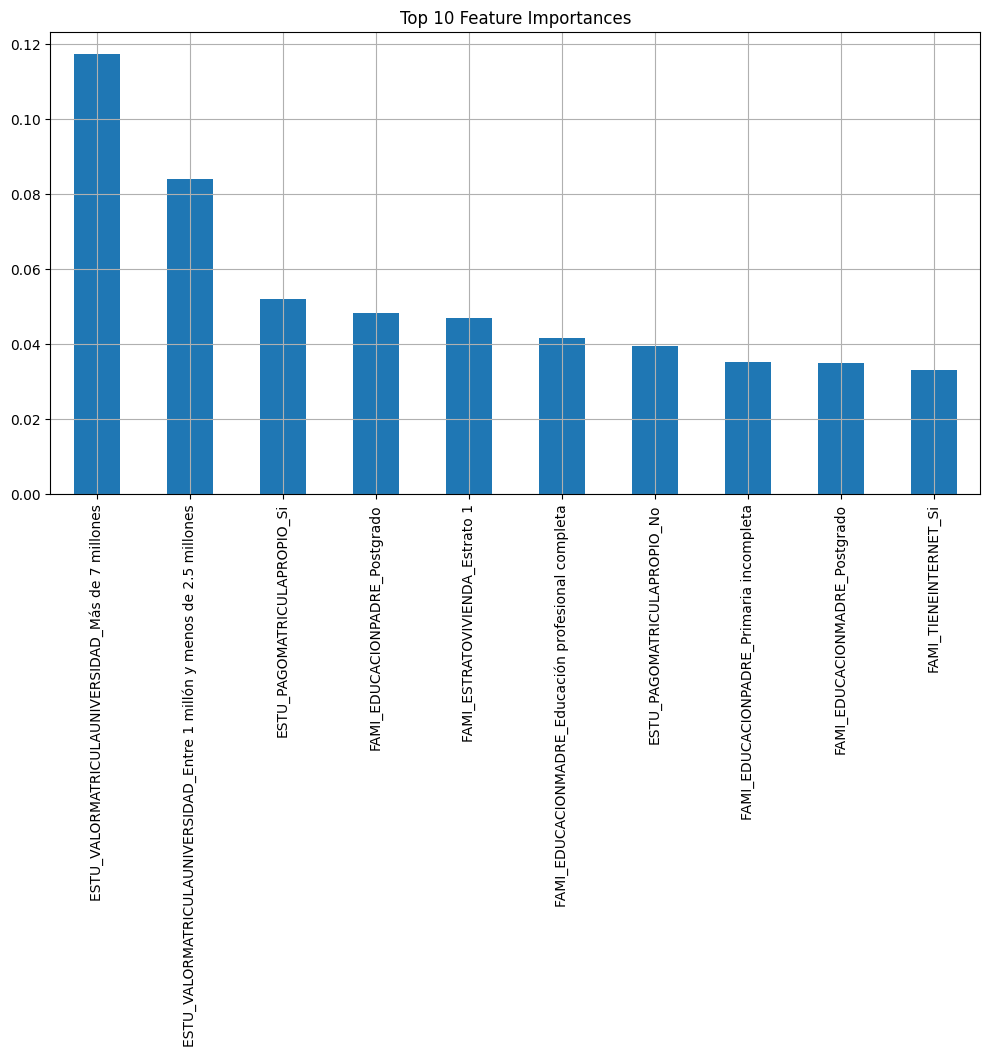

In [ ]:
yval_pred = clf.predict(Xval)
acc = accuracy_score(yval, yval_pred)
print(f"Accuracy en validación: {acc:.4f}")
scores = cross_val_score(clf, X, y, cv=5)
print(f"CV Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

clf.fit(X, y)
y_pred = clf.predict(test)

submission = pd.DataFrame({
    'ID': test['ID'],
    'RENDIMIENTO_GLOBAL': pd.Series(y_pred).map(inv_mapa)
})
submission.to_csv("submission.csv", index=False)
print("Primeras filas del archivo submission:")
print(submission.head())

importances = clf.feature_importances_
feat_names = X.columns
feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)

top_n = 10
feat_imp.head(top_n).plot(kind='bar', figsize=(12, 6), title=f"Top {top_n} Feature Importances")
plt.grid(); plt.tight_layout()
